In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

## Loading the data into the pandas dataframe

In [2]:
df=pd.read_csv("eth_1D.csv")
df=df.rename(columns={'Unnamed: 0': 'timestamp'})
df=df.set_index("timestamp")

## Feature Engineering

In [3]:
def createFeatures(df):
    et = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    
    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    df['HL']=df['High']-df['Low']
    df['upper shadow']=df['High']-df[['Close','Open']].max(axis=1)
    df['lower shadow']=df[['Close','Open']].min(axis=1)-df['Low']
    df['volatility indicator']=(df['High']-df['Low'])/df['VWAP']
    df['trend indicator']=(df['Close']-df['Open'])/df['VWAP']
    df['log return']=np.log(df['Close']/df['Open'])
    df['Momentum indicator']=(df['Close']-df['VWAP'])/df['VWAP']
    df['log volume']=np.log(1+df['Volume'])
    df['log count']=np.log(1+df['Count'])
    df['VOL 2 CNT']=df['Volume']/(1+df['Count'])
    
    return df

In [4]:
createFeatures(df)

,Count,Open,High,Low,Close,Volume,VWAP,Final_Target,Close_Diff,MA200,...,HL,upper shadow,lower shadow,volatility indicator,trend indicator,log return,Momentum indicator,log volume,log count,VOL 2 CNT
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.010036,0.160354,0.161169,0.159750,0.160368,0.011442,0.160364,0.643898,NaN,NaN,...,0.001420,0.000801,0.000605,0.008854,0.000088,0.000088,0.000025,0.011377,0.009986,0.011328
2018-01-03,0.027393,0.184952,0.185561,0.184260,0.184976,0.052724,0.184965,0.895602,0.024608,NaN,...,0.001301,0.000585,0.000692,0.007036,0.000129,0.000129,0.000060,0.051381,0.027024,0.051318
2018-01-04,0.022018,0.193539,0.194014,0.192759,0.193565,0.039917,0.193553,0.674273,0.008590,NaN,...,0.001254,0.000448,0.000779,0.006481,0.000138,0.000138,0.000066,0.039141,0.021779,0.039057
2018-01-05,0.024148,0.209060,0.209571,0.208287,0.209073,0.045182,0.209064,0.587664,0.015507,NaN,...,0.001284,0.000498,0.000773,0.006142,0.000061,0.000061,0.000041,0.044191,0.023861,0.044117
2018-01-06,0.024597,0.216215,0.217493,0.214946,0.216226,0.039310,0.216220,0.357411,0.007154,NaN,...,0.002547,0.001266,0.001269,0.011779,0.000055,0.000055,0.000029,0.038557,0.024300,0.038367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-18,0.146027,0.822811,0.821519,0.824028,0.822843,0.059296,0.822832,0.495328,-0.027926,0.597041,...,-0.002509,-0.001323,-0.001217,-0.003049,0.000039,0.000039,0.000012,0.057604,0.136301,0.051740
2021-09-19,0.115638,0.818043,0.816668,0.819434,0.818103,0.044050,0.818097,0.540849,-0.004740,0.599368,...,-0.002766,-0.001435,-0.001391,-0.003381,0.000074,0.000074,0.000007,0.043108,0.109426,0.039484
2021-09-20,0.109731,0.798933,0.797551,0.800286,0.798971,0.038082,0.798970,0.561850,-0.019132,0.601550,...,-0.002735,-0.001420,-0.001353,-0.003424,0.000048,0.000048,0.000001,0.037375,0.104117,0.034316


In [5]:
df.isnull().sum()

Count                     0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
VWAP                      0
Final_Target              0
Close_Diff                1
MA200                   199
MA100                    99
MA50                     49
MA26                     25
MA20                     19
MA12                     11
DIFF-MA200-MA50         199
DIFF-MA200-MA100        199
DIFF-MA200-CLOSE        199
DIFF-MA100-CLOSE         99
DIFF-MA50-CLOSE          49
MA200_low               199
MA14_low                 13
MA200_high              199
MA14_high                13
MA20dSTD                 19
EMA12                     0
EMA20                     0
EMA26                     0
EMA100                    0
EMA200                    0
close_shift-1             1
close_shift-2             2
Bollinger_Upper          19
Bollinger_Lower          19
K-ratio                  13
RSI                 

In [6]:
df.dropna(inplace=True)

In [7]:
x=df.drop("Final_Target",axis=1)

In [8]:
y=df['Final_Target']

In [9]:
#Splitting the data into train and test
X_train, X_test= np.split(x, [int(.70 *len(x))])
y_train, y_test= np.split(y, [int(.70 *len(y))])

In [10]:
X_train.corr()

,Count,Open,High,Low,Close,Volume,VWAP,Close_Diff,MA200,MA100,...,HL,upper shadow,lower shadow,volatility indicator,trend indicator,log return,Momentum indicator,log volume,log count,VOL 2 CNT
Count,1.000000,0.368014,0.368456,0.367759,0.368007,0.891661,0.367987,-0.079641,-0.205760,-0.021168,...,-0.117373,-0.119282,-0.103465,-0.006269,-0.020296,-0.020285,0.127839,0.895429,0.999548,0.882677
Open,0.368014,1.000000,0.999911,0.999962,1.000000,0.039679,1.000000,-0.004105,0.355685,0.652492,...,-0.404321,-0.411516,-0.347863,-0.102778,-0.064192,-0.064225,0.035858,0.046786,0.372259,0.027168
High,0.368456,0.999911,1.000000,0.999784,0.999912,0.041054,0.999911,-0.004035,0.356956,0.651814,...,-0.392574,-0.399353,-0.338265,-0.091380,-0.063148,-0.063181,0.036854,0.048191,0.372669,0.028586
Low,0.367759,0.999962,0.999784,1.000000,0.999962,0.038911,0.999962,-0.003662,0.353450,0.651932,...,-0.411613,-0.417623,-0.356060,-0.108899,-0.064199,-0.064233,0.035466,0.046082,0.372040,0.026425
Close,0.368007,1.000000,0.999912,0.999962,1.000000,0.039673,1.000000,-0.004055,0.355681,0.652488,...,-0.404320,-0.411513,-0.347866,-0.102772,-0.064152,-0.064185,0.035871,0.046781,0.372253,0.027164
Volume,0.891661,0.039679,0.041054,0.038911,0.039673,1.000000,0.039653,-0.082448,-0.193106,-0.136636,...,0.078250,0.077542,0.066721,0.102833,0.017864,0.017906,0.129876,0.993872,0.889360,0.997720
VWAP,0.367987,1.000000,0.999911,0.999962,1.000000,0.039653,1.000000,-0.004061,0.355690,0.652497,...,-0.404326,-0.411518,-0.347872,-0.102778,-0.064160,-0.064194,0.035855,0.046761,0.372233,0.027144
Close_Diff,-0.079641,-0.004105,-0.004035,-0.003662,-0.004055,-0.082448,-0.004061,1.000000,-0.164006,-0.164957,...,-0.014852,0.003995,-0.044541,0.002904,0.190458,0.190504,0.041983,-0.058848,-0.072960,-0.067332
MA200,-0.205760,0.355685,0.356956,0.353450,0.355681,-0.193106,0.355690,-0.164006,1.000000,0.887176,...,0.011517,-0.056913,0.113972,0.132045,-0.005453,-0.005452,-0.019996,-0.209037,-0.210231,-0.200780
MA100,-0.021168,0.652492,0.651814,0.651932,0.652488,-0.136636,0.652497,-0.164957,0.887176,1.000000,...,-0.267339,-0.310841,-0.169826,-0.060985,-0.038356,-0.038372,-0.005871,-0.147868,-0.022770,-0.147944


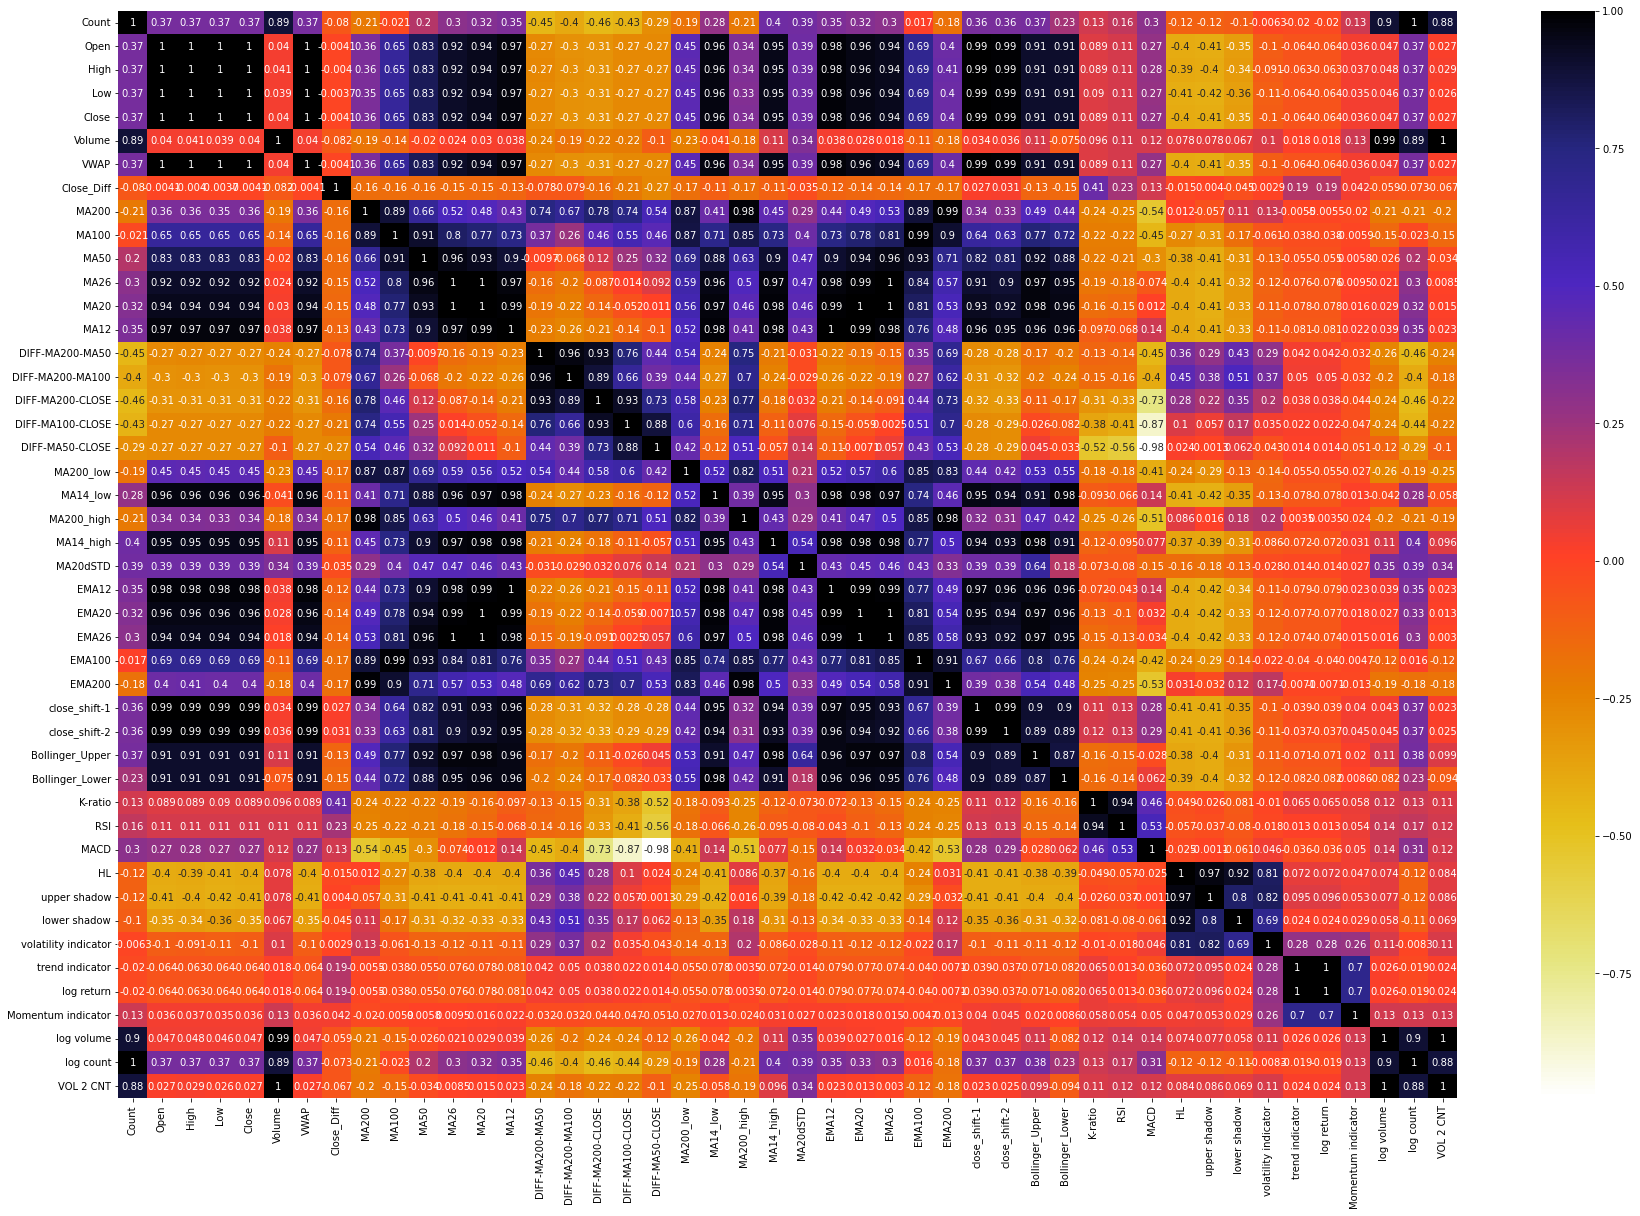

In [11]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(30,20))
cor =X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [12]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [13]:
corr_features = correlation(X_train, 0.7)
len(set(corr_features))

38

In [14]:
corr_features

{'Bollinger_Lower',
 'Bollinger_Upper',
 'Close',
 'DIFF-MA100-CLOSE',
 'DIFF-MA200-CLOSE',
 'DIFF-MA200-MA100',
 'DIFF-MA200-MA50',
 'DIFF-MA50-CLOSE',
 'EMA100',
 'EMA12',
 'EMA20',
 'EMA200',
 'EMA26',
 'High',
 'Low',
 'MA100',
 'MA12',
 'MA14_high',
 'MA14_low',
 'MA20',
 'MA200_high',
 'MA200_low',
 'MA26',
 'MA50',
 'MACD',
 'Momentum indicator',
 'RSI',
 'VOL 2 CNT',
 'VWAP',
 'Volume',
 'close_shift-1',
 'close_shift-2',
 'log count',
 'log return',
 'log volume',
 'lower shadow',
 'upper shadow',
 'volatility indicator'}

In [15]:
X_train=X_train.drop(corr_features,axis=1)
X_test=X_test.drop(corr_features,axis=1)

In [16]:
X_train.shape,X_test.shape

((810, 8), (348, 8))

In [17]:
X_train.isnull().sum()

Count              0
Open               0
Close_Diff         0
MA200              0
MA20dSTD           0
K-ratio            0
HL                 0
trend indicator    0
dtype: int64

In [18]:
X_test.isnull().sum()

Count              0
Open               0
Close_Diff         0
MA200              0
MA20dSTD           0
K-ratio            0
HL                 0
trend indicator    0
dtype: int64

In [19]:
X_train.head()

,Count,Open,Close_Diff,MA200,MA20dSTD,K-ratio,HL,trend indicator
timestamp,,,,,,,,
2018-07-20,0.020552,0.094474,-0.005098,0.147355,0.004477,67.431285,-0.000705,0.000059
2018-07-21,0.023603,0.090761,-0.003714,0.147007,0.004433,41.562805,-0.000638,0.000053
2018-07-22,0.014200,0.091049,0.000291,0.146537,0.004399,43.587738,-0.000660,0.000086
2018-07-23,0.011391,0.091895,0.000844,0.146029,0.004400,49.469127,-0.000657,0.000063
2018-07-24,0.017890,0.091108,-0.000787,0.145439,0.004359,43.985166,-0.000607,0.000061


## Hyperparameter tuning

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [21]:
param_grid = {'C': [1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}

In [22]:
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [23]:
print(grid.best_estimator_)

SVR(C=1, gamma=0.001)


## Model Training

In [55]:
model = SVR(kernel='rbf',gamma=0.05, C=1)

In [56]:
model.fit(X_train,y_train)

SVR(C=1, gamma=0.05)

In [57]:
predictions=model.predict(X_test)

In [58]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100


In [59]:
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))
#Test MAPE
MAPE=mean_absolute_percentage_error1(y_test, predictions)
print('MAPE:',MAPE)

MSE: 0.007218297274328331
RMSE: 0.08496056305326802
MAPE: 11.05945980681246


In [60]:
SVR_results = y_test.to_frame()
SVR_results["Predicted Return"] = predictions
SVR_results

,Final_Target,Predicted Return
timestamp,,
2020-10-08,0.547144,0.528568
2020-10-09,0.585405,0.532439
2020-10-10,0.609649,0.581809
2020-10-11,0.566386,0.557471
2020-10-12,0.546391,0.541011
...,...,...
2021-09-16,0.596568,0.582919
2021-09-17,0.583110,0.546040
2021-09-18,0.495328,0.551668


<AxesSubplot:xlabel='timestamp'>

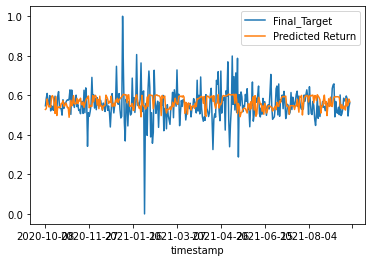

In [61]:
SVR_results.plot()

In [62]:
#Evaluate the model using just the "Y" training data:

in_sample_results_svr=y_train.to_frame()
print(in_sample_results_svr.shape)

in_sample_results_svr["In-sample Pred"]=model.predict(X_train)

in_sample_mse_svr=mean_squared_error(y_train, in_sample_results_svr["In-sample Pred"])
print("MSE:", in_sample_mse_svr)

rmse = np.sqrt(in_sample_mse_svr)
print("RMSE:", rmse)

#Train MAPE
MAPE=mean_absolute_percentage_error1(y_train, in_sample_results_svr["In-sample Pred"])
print("MAPE:",MAPE)

(810, 1)
MSE: 0.002577309020080864
RMSE: 0.05076720417829668
MAPE: 6.875246078773467
